**Tutorial # 3 - Contrast agnostic training**

Goals:

1.   Create synthetic images
2.   Determine GMM parameters

**Import libraries**

In [5]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt # plotting purposes

import tensorflow as tf
import os
from os.path import join, basename
import os.path
from tensorflow import keras
from tensorflow.keras import layers
import cv2


**Mount drive**

In [12]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# **START**

---



---



---



---



**Define parameters**

In [ ]:
# dataset parameters
FNAME_PATTERN = 'drive/MyDrive/MISAFinal/'

N_VOLUMES = 10
IMAGE_SIZE = (256,128,256)

# network parameters
N_CLASSES = 5
N_INPUT_CHANNELS = 1
PATCH_SIZE = (64, 64)
PATCH_STRIDE = (32, 32)

# data preparation parameters
CONTENT_THRESHOLD = 0.3

# training parameters
N_EPOCHS = 50
BATCH_SIZE = 64
PATIENCE = 10
MODEL_FNAME_PATTERN = 'model.h5'
OPTIMISER = 'Adam'
LOSS = 'categorical_crossentropy'

**Define SegNet architecture**

# **Unet**

---



---



---



---



In [ ]:
def get_unet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scale=1):
    inputs = keras.Input(shape=img_size + (n_input_channels, ))
    dropout_rate = 0.2
    # Encoding path
    conv1 = layers.Conv2D(32*scale, (3, 3), padding="same", activation='relu')(inputs)
    conv1 = layers.Conv2D(32*scale, (3, 3), padding="same", activation='relu') (conv1)
    #drop1 = layers.Dropout(rate=dropout_rate)(conv1, training=True)
    max1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(max1)
    conv2 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(conv2)
    #drop2 = layers.Dropout(rate=dropout_rate)(conv2, training=True)
    max2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(128*scale, (3, 3), padding="same", activation='relu')(max2)
    conv3 = layers.Conv2D(128*scale, (3, 3), padding="same", activation='relu')(conv3)
    #drop3 = layers.Dropout(rate=dropout_rate)(conv3, training=True)
    max3 = layers.MaxPooling2D((2, 2))(conv3)

    lat = layers.Conv2D(256*scale, (3, 3), padding="same", activation='relu')(max3)

    # Decoding path
    up1 = layers.UpSampling2D((2, 2))(lat)
    concat1 = layers.concatenate([conv3, up1], axis=-1)
    conv4 = layers.Conv2D(128*scale, (3, 3), padding="same", activation='relu')(concat1)
    conv4 = layers.Conv2D(128*scale, (3, 3), padding="same", activation='relu')(conv4)
    #drop4 = layers.Dropout(rate=dropout_rate)(conv4, training=True)

    up2 = layers.UpSampling2D((2, 2))(conv4)
    concat2 = layers.concatenate([conv2, up2], axis=-1)
    conv5 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(concat2)
    conv5 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(conv5)
    #drop5 = layers.Dropout(rate=dropout_rate)(conv5, training=True)

    up3 = layers.UpSampling2D((2, 2))(conv5)
    concat3 = layers.concatenate([conv1, up3], axis=-1)
    conv6 = layers.Conv2D(32*scale, (3, 3), padding="same", activation='relu')(concat3)
    conv6 = layers.Conv2D(32*scale, (3, 3), padding="same", activation='relu')(conv6)
    #drop6 = layers.Dropout(rate=dropout_rate)(conv6, training=True)

    outputs = layers.Conv2D(n_classes, (1, 1), activation="softmax")(conv6)

    model = keras.Model(inputs, outputs)

    return model

**Load raw data**

---



---



---



---



In [ ]:
def load_data(n_volumes, image_size,data_path):
  data_traces= os.listdir(data_path)
  T1_volumes = np.zeros((n_volumes, *image_size, 1))
  labels = np.zeros((n_volumes, *image_size, 1))
  x=0
  for i in enumerate(data_traces) :
    print(i[1])
  
    img_data = nib.load(data_path+'/'+f'{i[1]}'+'/'+f'{i[1]}_5labels_preprocessed.nii.gz')
    #img_data = nib.load(fname_pattern.format(i+1, 'T1'))
    T1_volumes[x] = img_data.get_fdata()

    seg_data = nib.load(data_path+'/'+f'{i[1]}'+'/'+f'{i[1]}_5labels_preprocessed_seg.nii.gz')
    labels[x] = seg_data.get_fdata()
    x=x+1

  return (T1_volumes, labels)

In [ ]:
(training_volumes_T1, training_labels) = load_data(7,IMAGE_SIZE,'drive/MyDrive/MISAFinal/TrainingValidationTestSets/Training_Set')

IBSR_16
IBSR_06
IBSR_03
IBSR_04
IBSR_08
IBSR_01
IBSR_07


In [ ]:
(validation_volumes_T1, validation_labels) = load_data(3,IMAGE_SIZE,'drive/MyDrive/MISAFinal/TrainingValidationTestSets/Validation_Set')

IBSR_18
IBSR_05
IBSR_09


In [ ]:
(testing_volumes_T1, testing_labels) = load_data(5,IMAGE_SIZE,'drive/MyDrive/MISAFinal/TrainingValidationTestSets/testing_Set')

IBSR_14
IBSR_13
IBSR_17
IBSR_11
IBSR_12


**Pre-process data**

---



---



---



---



**Extract *useful* patches**

This step is fundamental, we want to provide the network with useful information
// Idea provided in Dr. Jose Bernal's Workshop


In [ ]:
def extract_patches(x, patch_size, patch_stride) :
  return tf.image.extract_patches(
    x,
    sizes=[1, *patch_size, 1],
    strides=[1, *patch_stride, 1],
    rates=[1, 1, 1, 1],
    padding='SAME', name=None)

In [ ]:
def extract_useful_patches(
    volumes, labels,
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    stride=PATCH_STRIDE,
    threshold=CONTENT_THRESHOLD,
    num_classes=N_CLASSES) :
  volumes = volumes.reshape([-1, image_size[1], image_size[2], 1])
  labels = labels.reshape([-1, image_size[1], image_size[2], 1])
  print(volumes.shape)

  vol_patches = extract_patches(volumes, patch_size, stride).numpy()
  seg_patches = extract_patches(labels, patch_size, stride).numpy()

  vol_patches = vol_patches.reshape([-1, *patch_size, 1])
  seg_patches = seg_patches.reshape([-1, *patch_size, ])
  print(vol_patches.shape)
  print(seg_patches.shape)


  foreground_mask = seg_patches != 0

  useful_patches = foreground_mask.sum(axis=(1, 2)) > threshold * np.prod(patch_size)

  vol_patches = vol_patches[useful_patches]
  seg_patches = seg_patches[useful_patches]
  print(seg_patches.shape[0])

  seg_patches = tf.keras.utils.to_categorical(
    seg_patches, num_classes=N_CLASSES, dtype='float32')
  
  return (vol_patches, seg_patches)

In [ ]:
# extract patches from training set
#(training_patches_seg, _) = extract_useful_patches(training_labels, training_labels)

(training_patches_T1,training_patches_seg) = extract_useful_patches(training_volumes_T1, training_labels)

# extract patches from validation set
(validation_patches_T1, validation_patches_seg) = extract_useful_patches(validation_volumes_T1, validation_labels)

(1792, 128, 256, 1)
(57344, 64, 64, 1)
(57344, 64, 64)
9631
(768, 128, 256, 1)
(24576, 64, 64, 1)
(24576, 64, 64)
4796


**Train network**

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=PATIENCE),
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FNAME_PATTERN, save_best_only=True)
]

segnet = get_unet()
segnet.compile(optimizer=OPTIMISER, loss=LOSS)
segnet.fit(
    x=training_patches_T1, 
    y=training_patches_seg,
    validation_data=(validation_patches_T1, validation_patches_seg),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=my_callbacks,
    verbose=1)

Epoch 1/50
151/151 [==============================] - 28s 179ms/step - loss: 0.4217 - val_loss: 0.2570
Epoch 2/50
151/151 [==============================] - 27s 176ms/step - loss: 0.2009 - val_loss: 0.1925
Epoch 3/50
151/151 [==============================] - 27s 176ms/step - loss: 0.1664 - val_loss: 0.1643
Epoch 4/50
151/151 [==============================] - 27s 176ms/step - loss: 0.1431 - val_loss: 0.1565
Epoch 5/50
151/151 [==============================] - 26s 175ms/step - loss: 0.1777 - val_loss: 0.1711
Epoch 6/50
151/151 [==============================] - 27s 176ms/step - loss: 0.1360 - val_loss: 0.1515
Epoch 7/50
151/151 [==============================] - 27s 177ms/step - loss: 0.1163 - val_loss: 0.1477
Epoch 8/50
151/151 [==============================] - 27s 176ms/step - loss: 0.1077 - val_loss: 0.1470
Epoch 9/50
151/151 [==============================] - 27s 177ms/step - loss: 0.1001 - val_loss: 0.1447
Epoch 10/50
151/151 [==============================] - 27s 176ms/step - l

**Load best model**

In [ ]:
segnet = get_unet(
    img_size=(IMAGE_SIZE[1], IMAGE_SIZE[2]),
    n_classes=N_CLASSES,
    n_input_channels=N_INPUT_CHANNELS)
segnet.compile(optimizer=OPTIMISER, loss=LOSS)
segnet.load_weights('model.h5')

In [ ]:
testing_volumes_T1_processed = testing_volumes_T1.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
testing_labels_processed = testing_labels.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])

testing_labels_processed = tf.keras.utils.to_categorical(
    testing_labels_processed, num_classes=5, dtype='float32')

**Predict labels for test data**

(256, 128, 256, 5)


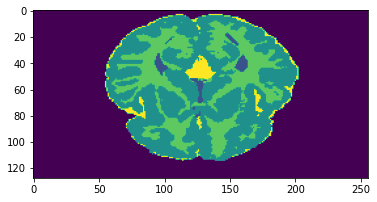

In [ ]:
prediction = segnet.predict(x=testing_volumes_T1[1])
print(prediction.shape)

prediction = np.argmax(prediction, axis=3)

plt.imshow(prediction[129, :, :])

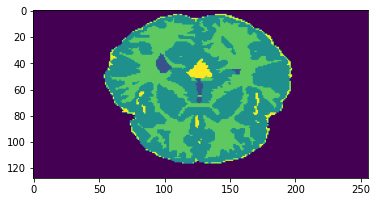

In [ ]:
plt.imshow(np.squeeze(testing_labels[0][129,:,:]))

In [ ]:
def compute_dice(prediction, labels) :
  prediction = prediction.squeeze()
  labels = labels.squeeze()
  dice=[]
  for c in np.unique(prediction) :
    intersection = np.logical_and(prediction == c, labels==c).sum()
    union = (prediction == c).sum() + (labels==c).sum()
    print(f'Dice coefficient class {c} equal to {2 * intersection / union : .2f}')
    dice.append(2 * intersection / union)
  return dice 

In [ ]:
dice_background=[]
dice_csf=[]
dice_wm=[]
dice_gm=[]
dices=[]

for i in range(5):
  prediction = segnet.predict(x=testing_volumes_T1[i])
  prediction = np.argmax(prediction, axis=3)
  dices=compute_dice(prediction, testing_labels[i])
  dice_background.append(dices[0])
  dice_csf.append(dices[1])
  dice_wm.append(dices[2])
  dice_gm.append(dices[3])

Dice coefficient class 0 equal to  1.00
Dice coefficient class 1 equal to  0.90
Dice coefficient class 2 equal to  0.95
Dice coefficient class 3 equal to  0.93
Dice coefficient class 4 equal to  0.83
Dice coefficient class 0 equal to  1.00
Dice coefficient class 1 equal to  0.88
Dice coefficient class 2 equal to  0.93
Dice coefficient class 3 equal to  0.90
Dice coefficient class 4 equal to  0.80
Dice coefficient class 0 equal to  1.00
Dice coefficient class 1 equal to  0.92
Dice coefficient class 2 equal to  0.94
Dice coefficient class 3 equal to  0.91
Dice coefficient class 4 equal to  0.76
Dice coefficient class 0 equal to  1.00
Dice coefficient class 1 equal to  0.87
Dice coefficient class 2 equal to  0.93
Dice coefficient class 3 equal to  0.94
Dice coefficient class 4 equal to  0.84
Dice coefficient class 0 equal to  1.00
Dice coefficient class 1 equal to  0.88
Dice coefficient class 2 equal to  0.92
Dice coefficient class 3 equal to  0.92
Dice coefficient class 4 equal to  0.84


In [ ]:
print(np.average(np.array(dice_background)))
print(np.average(np.array(dice_csf)))
print(np.average(np.array(dice_wm)))
print(np.average(np.array(dice_gm)))

0.9993812625649428
0.892405692294021
0.9332652158816886
0.9197466032235029
